### Informações do Conjunto de Treinamento ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4683 entries, 0 to 4682
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              4683 non-null   int64  
 1   tipo            4683 non-null   object 
 2   bairro          4683 non-null   object 
 3   tipo_vendedor   4683 non-null   object 
 4   quartos         4683 non-null   int64  
 5   suites          4683 non-null   int64  
 6   vagas           4683 non-null   int64  
 7   area_util       4683 non-null   int64  
 8   area_extra      4683 non-null   int64  
 9   diferenciais    4683 non-null   object 
 10  churrasqueira   4683 non-null   int64  
 11  estacionamento  4683 non-null   int64  
 12  piscina         4683 non-null   int64  
 13  playground      4683 non-null   int64  
 14  quadra          4683 non-null   int64  
 15  s_festas        4683 non-null   int64  
 16  s_jogos         4683 non-null  

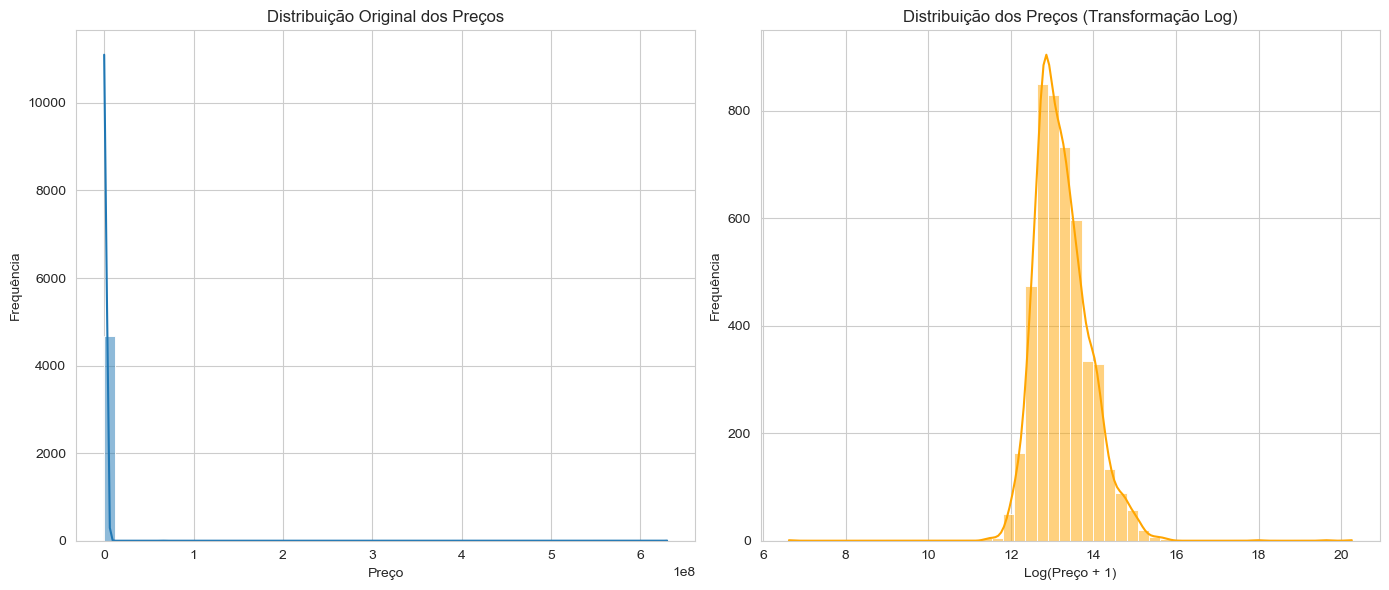

In [27]:
# Importando as bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Carregando os dados
try:
    # Caso esteja rodando localmente
    df_treinamento = pd.read_csv('conjunto_de_treinamento_reg.csv')
    df_teste = pd.read_csv('conjunto_de_teste_reg.csv')
except FileNotFoundError:
    # Adicione aqui o caminho correto se os arquivos não estiverem na mesma pasta
    print("Arquivos não encontrados. Verifique o caminho.")
    # Exemplo: df_train = pd.read_csv('/caminho/para/seu/arquivo/conjunto_de_treinamento.csv')

# Vamos dar uma olhada inicial nos dados de treinamento
print("### Informações do Conjunto de Treinamento ###")
df_treinamento.info()

print("\n### 5 Primeiras Linhas do Conjunto de Treinamento ###")
print(df_treinamento.head())

print("\n### Estatísticas Descritivas (Numéricas) ###")
print(df_treinamento.describe())

# --- Análise da Variável Alvo: 'preco' ---

# 1. Histograma do preço original
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_treinamento['preco'], kde=True, bins=50)
plt.title('Distribuição Original dos Preços')
plt.xlabel('Preço')
plt.ylabel('Frequência')

# 2. Histograma do preço com transformação logarítmica
# Usamos np.log1p que calcula log(1 + x) para evitar problemas com valores de preço iguais a zero.
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df_treinamento['preco']), kde=True, bins=50, color='orange')
plt.title('Distribuição dos Preços (Transformação Log)')
plt.xlabel('Log(Preço + 1)')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

In [28]:
# --- 1. CARREGAMENTO E PREPARAÇÃO INICIAL ---
# Carregue os dataframes originais
df_treinamento = pd.read_csv('conjunto_de_treinamento_reg.csv')
df_teste = pd.read_csv('conjunto_de_teste_reg.csv')

print("Dataframes originais carregados.")
print(f"Tamanho do treino: {df_treinamento.shape}")
print(f"Tamanho do teste: {df_teste.shape}")

# Guarde os IDs de teste e o alvo (target) já com a transformação logarítmica
test_ids = df_teste['Id']
target_log = np.log1p(df_treinamento['preco'])

# --- 2. LIMPEZA DE DADOS (CONSISTENTE) ---
print("\nIniciando limpeza de dados...")

# Calcule as medianas UMA VEZ, apenas com dados de treino, para evitar data leakage.
median_suites = df_treinamento['suites'].median()
median_area_util = df_treinamento['area_util'].median()
median_area_extra = df_treinamento['area_extra'].median()

# Use um loop para aplicar as mesmas transformações em ambos os dataframes
for df in [df_treinamento, df_teste]:
    # Preenche valores nulos com as medianas do TREINO
    df['suites'].fillna(median_suites, inplace=True)
    df['area_util'].fillna(median_area_util, inplace=True)
    df['area_extra'].fillna(median_area_extra, inplace=True)
    
    # Corrige a 'area_util' igual a zero com a mediana do TREINO
    df['area_util'].replace(0, median_area_util, inplace=True)

print("Limpeza de dados nulos e de 'area_util == 0' concluída.")

# --- 3. ENGENHARIA DE FEATURES ---
print("\nIniciando engenharia de features...")

# Parte A: Features Simples
for df in [df_treinamento, df_teste]:
    df['area_total'] = df['area_util'] + df['area_extra']
    df['prop_suites_quartos'] = np.divide(df['suites'], df['quartos']).fillna(0)
    diferenciais_cols = ['churrasqueira', 'estacionamento', 'piscina', 'playground', 
                          'quadra', 's_festas', 's_jogos', 's_ginastica', 'sauna', 'vista_mar']
    df['total_diferenciais'] = df[diferenciais_cols].sum(axis=1)
print("Features simples criadas.")

# Parte B: Features Avançadas (baseadas em 'bairro')
# Calcule o preço/m² apenas no treino para criar as estatísticas
df_treinamento['preco_m2'] = df_treinamento['preco'] / df_treinamento['area_util']
df_treinamento['preco_m2'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Calcule as estatísticas do bairro USANDO APENAS O CONJUNTO DE TREINO
bairro_stats = df_treinamento.groupby('bairro').agg(
    preco_m2_mediano_bairro=('preco_m2', 'median'),
    imoveis_por_bairro=('Id', 'count'),
    preco_std_bairro=('preco', 'std')
).reset_index()

# Junte (merge) as estatísticas em AMBOS os dataframes
df_treinamento = pd.merge(df_treinamento, bairro_stats, on='bairro', how='left')
df_teste = pd.merge(df_teste, bairro_stats, on='bairro', how='left')

# Preencha possíveis nulos gerados no merge
# (caso um bairro do teste não estivesse no treino)
for col in ['preco_m2_mediano_bairro', 'imoveis_por_bairro', 'preco_std_bairro']:
    global_median = df_treinamento[col].median()
    df_treinamento[col].fillna(global_median, inplace=True)
    df_teste[col].fillna(global_median, inplace=True)
print("Features avançadas de 'bairro' criadas.")


# --- 4. FINALIZAÇÃO ---
print("\nFinalizando preparação dos dataframes...")

# Remova as colunas que não são features para o modelo
# 'preco_m2' foi apenas um passo intermediário
df_treinamento_final = df_treinamento.drop(columns=['Id', 'preco', 'preco_m2'])
df_teste_final = df_teste.drop(columns=['Id'])

# Garanta que a ordem das colunas seja a mesma
df_teste_final = df_teste_final[df_treinamento_final.columns]

print("\nProcesso concluído!")
print(f"Tamanho do df_treinamento_final: {df_treinamento_final.shape}")
print(f"Tamanho do df_teste_final: {df_teste_final.shape}")
print("\nPrévia do dataframe de treino final:")
print(df_treinamento_final.head())

Dataframes originais carregados.
Tamanho do treino: (4683, 21)
Tamanho do teste: (2000, 20)

Iniciando limpeza de dados...
Limpeza de dados nulos e de 'area_util == 0' concluída.

Iniciando engenharia de features...
Features simples criadas.
Features avançadas de 'bairro' criadas.

Finalizando preparação dos dataframes...

Processo concluído!
Tamanho do df_treinamento_final: (4683, 25)
Tamanho do df_teste_final: (2000, 25)

Prévia do dataframe de treino final:
          tipo        bairro tipo_vendedor  quartos  suites  vagas  area_util  \
0         Casa   Imbiribeira   Imobiliaria        3       3      5        223   
1  Apartamento  Casa Amarela   Imobiliaria        4       4      2        157   
2  Apartamento  Encruzilhada   Imobiliaria        3       1      0         53   
3  Apartamento    Boa Viagem   Imobiliaria        4       3      2        149   
4  Apartamento     Rosarinho   Imobiliaria        2       1      1         54   

   area_extra             diferenciais  churrasq

C:\Users\Danilo\AppData\Local\Temp\ipykernel_10132\3293147245.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['suites'].fillna(median_suites, inplace=True)
C:\Users\Danilo\AppData\Local\Temp\ipykernel_10132\3293147245.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

In [29]:
# Imports gerais
import pandas as pd
import numpy as np

# Pré-processamento
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder

# Métricas
from sklearn.metrics import make_scorer, mean_squared_error

# --- Definição da Métrica Customizada (RMSPE) ---
def rmspe(y_true_log, y_pred_log):
    """
    Calcula a Raiz Quadrada do Erro Percentual Quadrático Médio (RMSPE).
    y_true_log e y_pred_log são os valores na escala logarítmica.
    """
    # Reverte a transformação logarítmica para obter os preços reais
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    
    # Adiciona um valor pequeno para evitar divisão por zero, caso algum preço real seja 0
    # (neste dataset, o preço mínimo é 100k, então não é um problema)
    
    # Calcula o erro percentual
    percentage_error = (y_true - y_pred) / y_true
    
    # Calcula a métrica final
    return np.sqrt(np.mean(np.square(percentage_error)))

# Transforma a função em um 'scorer' utilizável pelo scikit-learn
# greater_is_better=False porque queremos minimizar o erro
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

In [30]:
# Assumindo que 'full_df' e 'target_log' foram criados nos passos anteriores
# Separando os dados de treino para a validação cruzada
n_train = len(df_treinamento)
X = df_treinamento[:n_train]
y = target_log

# Identificando os tipos de colunas
# (Excluindo as colunas que criamos e a coluna de texto original)
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features_low = ['tipo', 'tipo_vendedor']
categorical_features_high = ['bairro']

# Removendo colunas que não queremos escalar diretamente (se houver)
# As colunas binárias de 'diferenciais' não precisam de scaling, mas não prejudica.
# Apenas para organização, vamos mantê-las na lista numérica por enquanto.

# Criando o transformador de colunas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat_low', OneHotEncoder(handle_unknown='ignore'), categorical_features_low),
        ('cat_high', TargetEncoder(), categorical_features_high)
    ],
    remainder='drop' # Descarta colunas não especificadas (como 'diferenciais')
)

In [31]:
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
%pip install xgboost
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


# Definindo os modelos que queremos testar
models = {
    "RandomForest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(random_state=42, n_jobs=-1),
    "DecisionTree": DecisionTreeRegressor(random_state=42)
}

# Configurando a validação cruzada
kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

# Dicionário para armazenar os resultados
results = {}

print("Iniciando a avaliação dos modelos com validação cruzada...")
print("Métrica: RMSPE (quanto menor, melhor)\n")

# Loop para iterar sobre cada modelo
for name, model in models.items():
    
    # Cria o pipeline completo: pré-processador + modelo
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Executa a validação cruzada
    # Usamos -score porque a função retorna valores negativos
    cv_scores = -cross_val_score(
        model_pipeline, X, y,
        cv=kf,
        scoring=rmspe_scorer,
        n_jobs=-1 # Usa todos os processadores
    )
    
    # Armazena a média e o desvio padrão dos scores
    results[name] = {
        'mean_rmspe': np.mean(cv_scores),
        'std_rmspe': np.std(cv_scores)
    }
    
    # Imprime o resultado do modelo atual
    print(f"Modelo: {name}")
    print(f"  - Média RMSPE: {results[name]['mean_rmspe']:.4f}")
    print(f"  - Desvio Padrão RMSPE: {results[name]['std_rmspe']:.4f}\n")

# --- Exibindo o ranking final dos modelos ---
print("\n--- Ranking Final dos Modelos ---")
results_df = pd.DataFrame(results).T.sort_values(by='mean_rmspe')
print(results_df)

Iniciando a avaliação dos modelos com validação cruzada...
Métrica: RMSPE (quanto menor, melhor)


Modelo: RandomForest
  - Média RMSPE: 0.6301
  - Desvio Padrão RMSPE: 1.7783

Modelo: XGBoost
  - Média RMSPE: 0.7412
  - Desvio Padrão RMSPE: 1.9384

Modelo: LightGBM
  - Média RMSPE: 0.8681
  - Desvio Padrão RMSPE: 2.4688

Modelo: DecisionTree
  - Média RMSPE: 0.6241
  - Desvio Padrão RMSPE: 1.7433


--- Ranking Final dos Modelos ---
              mean_rmspe  std_rmspe
DecisionTree    0.624066   1.743301
RandomForest    0.630097   1.778312
XGBoost         0.741162   1.938440
LightGBM        0.868070   2.468817


In [ ]:

import optuna

# Assumindo que 'X', 'y', 'preprocessor', 'kf', e 'rmspe_scorer' já estão definidos.

# 1. Defina a função "objetivo" para o RandomForest
def objective_rf(trial):
    """
    Função objetivo para otimizar o RandomForestRegressor com Optuna.
    """
    # Hiperparâmetros mais importantes para uma Árvore de Decisão

    # # Hiperparâmetros mais importantes para o XGBoost
    # param = {
    #     # Define o tipo de modelo a ser construído. 'gbtree' usa árvores de decisão.
    #     'booster': 'gbtree',
        
    #     # Taxa de aprendizado. Reduz o peso de cada nova árvore para evitar overfitting.
    #     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        
    #     # Número de árvores (rodadas de boosting) a serem criadas.
    #     'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
        
    #     # Profundidade máxima de cada árvore.
    #     'max_depth': trial.suggest_int('max_depth', 3, 15),
        
    #     # Soma mínima dos pesos das amostras necessárias em um nó filho. Controla o overfitting.
    #     'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        
    #     # Fração de amostras (linhas) a serem usadas para treinar cada árvore.
    #     'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        
    #     # Fração de features (colunas) a serem usadas para treinar cada árvore.
    #     'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        
    #     # Redução mínima de perda necessária para fazer uma partição. Controla a criação de novos nós.
    #     'gamma': trial.suggest_float('gamma', 0, 5),
        
    #     # Regularização L1 (Lasso).
    #     'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        
    #     # Regularização L2 (Ridge).
    #     'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        
    #     # Para reprodutibilidade.
    #     'random_state': 42
    # }

    # Hiperparâmetros mais importantes para uma Árvore de Decisão

    # param = {
    #     # Critério para medir a qualidade da divisão. 'squared_error' é o padrão.
    #     'criterion': trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error']),
        
    #     # Profundidade máxima da árvore. Controla a complexidade.
    #     'max_depth': trial.suggest_int('max_depth', 5, 40),
        
    #     # Número mínimo de amostras necessárias para dividir um nó.
    #     'min_samples_split': trial.suggest_int('min_samples_split', 2, 40),
        
    #     # Número mínimo de amostras que um nó folha (leaf) deve ter.
    #     'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 40),
        
    #     # Número de features a considerar ao procurar a melhor divisão.
    #     'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        
    #     # Para reprodutibilidade dos resultados.
    #     'random_state': 42
    # }

    # Crie o pipeline com o RandomForest
    dt_optuna = DecisionTreeRegressor(**param)
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', dt_optuna)
    ])

    # Calcule o score usando validação cruzada
    score = cross_val_score(
        pipeline, X, y,
        cv=kf,
        scoring=rmspe_scorer,
        n_jobs=-1
    )

    return score.mean()

# 2. Crie e execute o estudo do Optuna
print("Iniciando o ajuste de hiperparâmetros para o RandomForest com Optuna...")
study_dt = optuna.create_study(direction='minimize')
study_dt.optimize(objective_rf, n_trials=50) # 50 tentativas é um bom começo

# 3. Exibindo os melhores resultados
print("\n--- Ajuste do RandomForest com Optuna Finalizado ---")
print(f"Melhor Score (RMSPE): {-study_dt.best_value:.4f}")
print("\nMelhores Hiperparâmetros Encontrados para o RandomForest:")
print(study_dt.best_params)

[I 2025-07-18 15:40:14,247] A new study created in memory with name: no-name-93b9a0ef-8961-4630-ad7b-674c9807a359


Iniciando o ajuste de hiperparâmetros para o RandomForest com Optuna...


[I 2025-07-18 15:40:17,124] Trial 0 finished with value: -1.3282192986804904 and parameters: {'criterion': 'friedman_mse', 'max_depth': 17, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: -1.3282192986804904.
[I 2025-07-18 15:40:18,469] Trial 1 finished with value: -1.563251400086127 and parameters: {'criterion': 'squared_error', 'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 31, 'max_features': 'sqrt'}. Best is trial 1 with value: -1.563251400086127.
[I 2025-07-18 15:40:23,366] Trial 2 finished with value: -1.4803942508460524 and parameters: {'criterion': 'absolute_error', 'max_depth': 35, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: -1.563251400086127.
[I 2025-07-18 15:40:24,583] Trial 3 finished with value: -1.8978406798810028 and parameters: {'criterion': 'friedman_mse', 'max_depth': 13, 'min_samples_split': 28, 'min_samples_leaf': 32, 'max_features': 'log2'}. 


--- Ajuste do RandomForest com Optuna Finalizado ---
Melhor Score (RMSPE): 1.9438

Melhores Hiperparâmetros Encontrados para o RandomForest:
{'criterion': 'friedman_mse', 'max_depth': 5, 'min_samples_split': 40, 'min_samples_leaf': 36, 'max_features': 'log2'}


In [34]:
# Assumindo que 'df_treinamento', 'df_teste', 'study_rf', 
# 'target_log' e 'test_ids' já foram definidos nos passos anteriores.

# --- ETAPA 1: PREPARAÇÃO FINAL E CONSISTENTE DOS DADOS ---

print("Preparando os dataframes finais para o modelo...")

# A. Defina o 'X' de treino, removendo colunas que não são features.
X = df_treinamento.drop(columns=['Id', 'preco', 'preco_m2'])

# B. Defina o 'y' (alvo), que já temos.
y = target_log

# C. Defina o 'X_test' de teste, removendo apenas o ID.
X_test = df_teste.drop(columns=['Id'])

# --- ETAPA 2: DEFINIÇÃO DO PREPROCESSADOR (NA ORDEM CORRETA) ---

print("Definindo o pré-processador com as colunas corretas...")

# A. CRIE AS LISTAS DE FEATURES *DEPOIS* DE CRIAR O X FINAL.
# Isso garante que 'Id' e 'preco' não estarão nessas listas.
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features_low = ['tipo', 'tipo_vendedor']
categorical_features_high = ['bairro']

# B. Crie o transformador de colunas (preprocessor).
# Agora ele só conhece as colunas que realmente existem em X.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat_low', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_low),
        ('cat_high', TargetEncoder(), categorical_features_high)
    ],
    remainder='drop' # Descarta colunas não especificadas (como 'diferenciais')
)

# C. GARANTA A CONSISTÊNCIA FINAL DAS COLUNAS DE TESTE
X_test = X_test[X.columns]

print("Verificação de consistência das colunas concluída.")
print(f"Shape de X (treino): {X.shape}")
print(f"Shape de X_test (teste): {X_test.shape}")

# --- ETAPA 3: CRIAÇÃO, TREINAMENTO E PREDIÇÃO DO MODELO FINAL ---

# Use os melhores parâmetros do Optuna
best_dt_params = study_dt.best_params
final_dt_model = DecisionTreeRegressor(**best_dt_params, random_state=42)

# Crie o pipeline final
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', final_dt_model)
])

# Treine o modelo
print("Treinando o modelo RandomForest final...")
final_model.fit(X, y)
print("Treinamento concluído.")

# Faça as predições
print("Realizando predições no conjunto de teste...")
predictions_log = final_model.predict(X_test)
final_predictions = np.expm1(predictions_log)
print("Predições finalizadas.")

# --- ETAPA 4: CRIAÇÃO DO ARQUIVO DE SUBMISSÃO ---

submission_df = pd.DataFrame({'Id': test_ids, 'preco': final_predictions})
submission_df['preco'] = submission_df['preco'].clip(lower=0)
submission_df.to_csv('submission_dt_optuna_final.csv', index=False)

print("\nArquivo 'submission_dt_optuna_final.csv' criado com sucesso!")
print(submission_df.head())

Preparando os dataframes finais para o modelo...
Definindo o pré-processador com as colunas corretas...
Verificação de consistência das colunas concluída.
Shape de X (treino): (4683, 25)
Shape de X_test (teste): (2000, 25)
Treinando o modelo RandomForest final...
Treinamento concluído.
Realizando predições no conjunto de teste...
Predições finalizadas.

Arquivo 'submission_dt_optuna_final.csv' criado com sucesso!
   Id         preco
0   0  1.261177e+06
1   1  3.325956e+05
2   2  6.134851e+05
3   3  2.768615e+05
4   4  3.108543e+05


In [36]:
sub_rf = pd.read_csv('submission_rf_optuna_final.csv') # Substitua pelo nome correto
sub_xgb = pd.read_csv('submission_xgb_optuna_final.csv') # O que acabamos de criar
sub_lgbm = pd.read_csv('submission_lgbm.csv') # O que acabamos de criar

# Ordene por ID para garantir que as linhas correspondem
sub_rf = sub_rf.sort_values('Id').reset_index(drop=True)
sub_xgb = sub_xgb.sort_values('Id').reset_index(drop=True)
sub_lgbm = sub_lgbm.sort_values('Id').reset_index(drop=True)

# Crie a previsão final com uma média ponderada
# Comece com 50/50, mas você pode testar pesos diferentes (ex: 0.6 e 0.4)
peso_modelo = 1 / 3
preco_final = (peso_modelo * sub_xgb['preco']) + (peso_modelo * sub_rf['preco']) + (peso_modelo * sub_lgbm['preco'])

# Crie o dataframe de submissão do ensemble
submission_ensemble = pd.DataFrame({'Id': sub_xgb['Id'], 'preco': preco_final})

# Salve o arquivo final
submission_ensemble.to_csv('submission_ensemble_rf_xgb_lgbm.csv', index=False)

print("Arquivo de submissão do ensemble criado com sucesso!")
print(submission_ensemble.head())

Arquivo de submissão do ensemble criado com sucesso!
   Id         preco
0   0  1.471003e+06
1   1  3.182980e+05
2   2  6.140236e+05
3   3  2.469357e+05
4   4  3.055094e+05


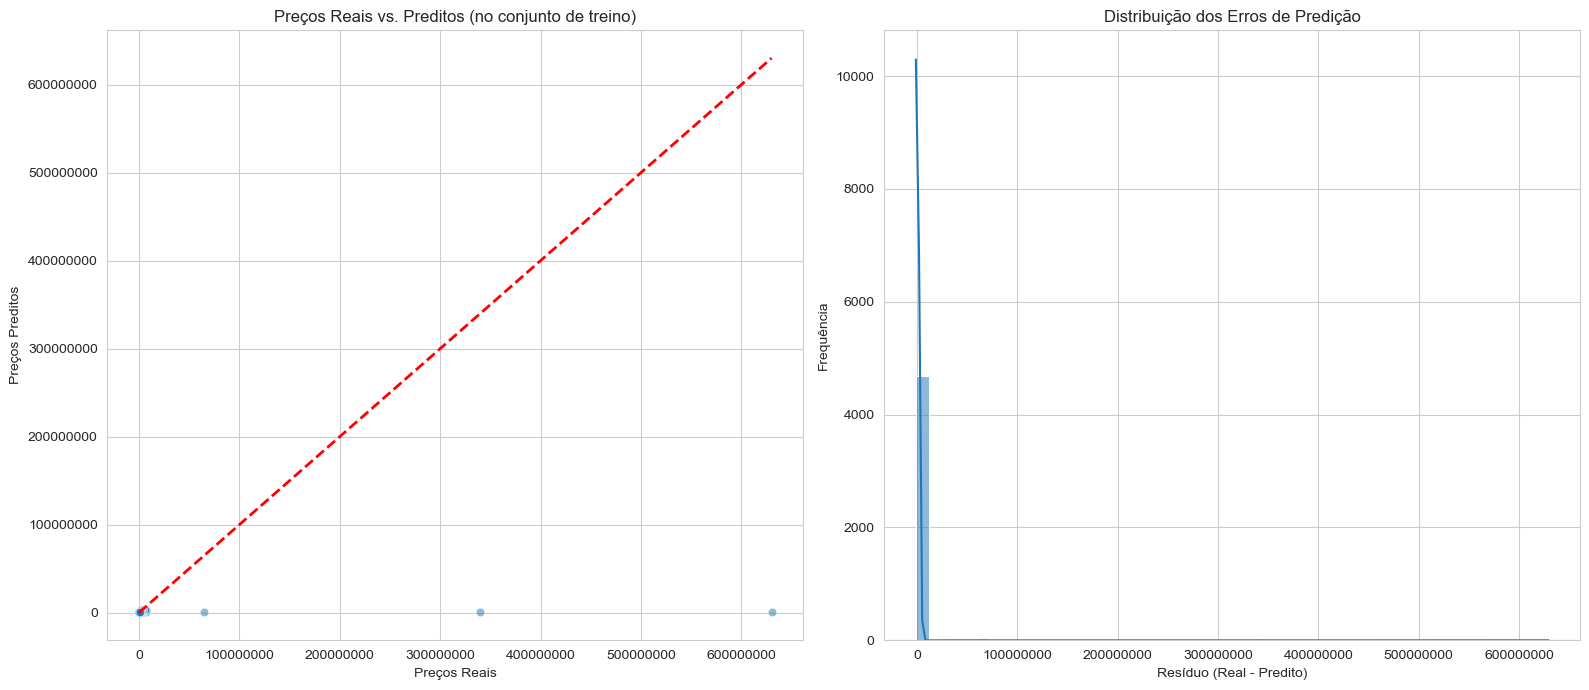

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Supondo que 'X' (features de treino), 'y' (target log de treino) e 'final_model' já existam

# Fazer predições no conjunto de treino (em escala log)
train_predictions_log = final_model.predict(X)

# Reverter as predições para a escala original
train_predictions_original = np.expm1(train_predictions_log)

# Reverter os valores reais (target) também para a escala original
y_train_original = np.expm1(y)

# Calcular os resíduos (erros)
residuos = y_train_original - train_predictions_original

# --- Gráfico de Predito vs. Real (Revisado) ---
plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train_original, y=train_predictions_original, alpha=0.5)
plt.plot([y_train_original.min(), y_train_original.max()], [y_train_original.min(), y_train_original.max()], '--r', linewidth=2)
plt.xlabel("Preços Reais")
plt.ylabel("Preços Preditos")
plt.title("Preços Reais vs. Preditos (no conjunto de treino)")
plt.gca().ticklabel_format(style='plain', axis='both')

# --- Gráfico da Distribuição dos Erros (Revisado) ---
plt.subplot(1, 2, 2)
sns.histplot(residuos, kde=True, bins=50)
plt.xlabel("Resíduo (Real - Predito)")
plt.ylabel("Frequência")
plt.title("Distribuição dos Erros de Predição")
plt.gca().ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()

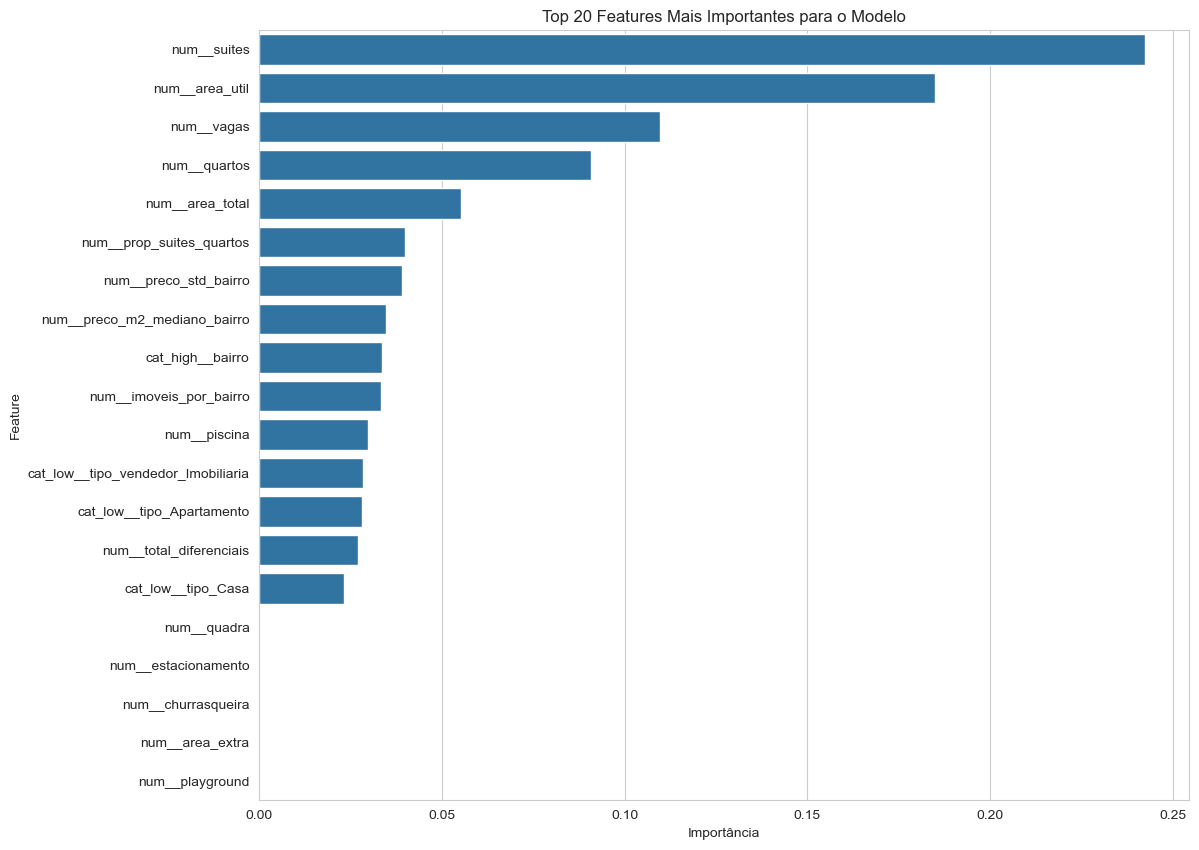

In [ ]:
# Extraindo os nomes das features do nosso pipeline
# Isso é um pouco complexo porque o ColumnTransformer muda os nomes
feature_names = final_model.named_steps['preprocessor'].get_feature_names_out()

# Extraindo as importâncias do modelo LightGBM
importances = final_model.named_steps['regressor'].feature_importances_

# Criando um DataFrame para facilitar a visualização
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)


# --- Gráfico de Importância das Features ---
plt.figure(figsize=(12, 10))
sns.barplot(
    x='importance', 
    y='feature', 
    data=feature_importance_df.head(20) # Mostrando as 20 features mais importantes
)
plt.title("Top 20 Features Mais Importantes para o Modelo")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.show()